In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
import math 
import scipy.spatial as ss
import scipy.ndimage

## Generate space coordinate and momentum grid

In [17]:
## Calculate the transformation matrix
coor_1d = np.array(range(20))/2. - 4.5
X, Y, Z = np.meshgrid(coor_1d, coor_1d, coor_1d)
max_coor= 5.

coordinate_flat = np.zeros((8000, 3))
coordinate_flat[:,0] = np.reshape(X, 8000)
coordinate_flat[:,1] = np.reshape(Y, 8000)
coordinate_flat[:,2] = np.reshape(Z, 8000)

np.save('./coordinate_grid_flat.npy',coordinate_flat)

## momentum space
edge_num = 512
## Number of fringes
num_fringe = 12
## maximum momentum
max_momentum = num_fringe* 2 * np.pi / max_coor * np.sqrt(2)

momentum = np.zeros((edge_num, edge_num, 3))
for l in range(edge_num):
    for m in range(edge_num):
        momentum[l,m,:] = (np.sin((l- edge_num/2)*np.pi/4/edge_num),
                           np.sin((m-edge_num/2)*np.pi/4/edge_num), 
                           1- np.sqrt(1- np.sin((l-edge_num/2)*np.pi/4/edge_num)**2 
                                      - np.sin((m-edge_num/2)*np.pi/4/edge_num)**2))
momentum *= max_momentum

momentum_flat = np.reshape(momentum,[edge_num**2, 3])
np.save('./momentum_grid.npy',momentum)

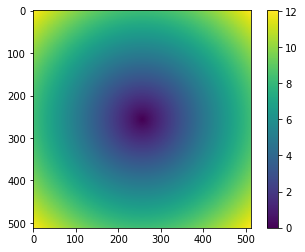

In [8]:
momentum_norm = np.sqrt(np.sum(np.square(momentum),axis=-1))

# show the momentum distribution
plt.imshow(momentum_norm)
plt.colorbar()
plt.show()

## Back up

In [13]:
@cuda.jit('void(float64[:], float64[:,:], float64[:,:], float64[:], float64[:], int32, int32)')
def Fourier_Transform(values, coor, momentum, patternCos, patternSin, coor_num, momen_num):    
    # c is the coordinate index
    # m is the momentum index
    c = cuda.grid(1)
    if c < coor_num :
        for m in range(momen_num):
            ## Initialize the variables
            holder = 0
            patternCos[m] = 0
            patternSin[m] = 0
            
            for l in range(3):
                holder += coor[c, l] * momentum[m , l]
            patternCos[m] +=  values[c]* math.cos(holder)
            patternSin[m] +=  values[c]* math.sin(holder)
            
@cuda.jit('void(float64, float64[:], float64[:], float64[:], float64[:], int32)')
def Target_and_Difference(target, patternCos, patternSin, measurement, difference, momen_num):
    c = cuda.grid(1)
    
    ## Initialize the target
    target = 0
    if c < momen_num:
        difference[c] = patternCos[c]*patternCos[c] + patternSin[c]*patternSin[c] - measurement[c]
        target += difference[c] 
        
@cuda.jit('void(float64[:],float64[:],float64[:],float64[:,:],float64[:,:], float64[:], int32,int32)')
def Gradient(difference, patternCos, patternSin, coor, momentum, gradient, coor_num, momen_num):
    # c is the coordinate index
    # m is the momentum index
    c = cuda.grid(1)
    if c < coor_num :
        gradient[c] = 0 # Initialize
        
        for m in range(momen_num):
            holder = 0 # Initialize 
            
            for l in range(3):
                holder += coor[c, l] * momentum[m , l]
                
            gradient[c] += 4*difference[m]* (patternCos[m]*math.cos(holder) +
                                           patternSin[m]*math.cos(holder))
            
'''@cuda.jit('void(int32, float64, float64, float64, float64[:], float64[:,:], float64[:], float64[:],float64[:,:], float64[:,:])')
def Line_Search(iter_num, decay_rate, step_size, stop_threshold, history_target, 
                history_values, initial_guess, measurement, coor, momentum):
    
    # Create a variable to detector the standard
    
    if 
    ## Calculate the Fourier transition of the initial guess
    Fourier_Transform(initial_guess, coor, momentum, patternCos, patternSin, coor_num, momen_num)'''

"@cuda.jit('void(int32, float64, float64, float64, float64[:], float64[:,:], float64[:], float64[:],float64[:,:], float64[:,:])')\ndef Line_Search(iter_num, decay_rate, step_size, stop_threshold, history_target, \n                history_values, initial_guess, measurement, coor, momentum):\n    \n    # Create a variable to detector the standard\n    \n    if \n    ## Calculate the Fourier transition of the initial guess\n    Fourier_Transform(initial_guess, coor, momentum, patternCos, patternSin, coor_num, momen_num)"